In [1]:
# 미세먼지 예측 프로그램

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# 데이터 로드
# 일간 미세먼지 시계열 데이터 최근 1달치 사용 (2023년 10월 제주)
# 데이터 소스: 에어코리아 (https://www.airkorea.or.kr/web/pmRelay?itemCode=11008&pMENU_NO=109)

from google.colab import files
uploaded = files.upload()

Saving pm25_2310_jeju.xls to pm25_2310_jeju.xls


In [11]:
# 업로드한 파일의 이름 추출
file_name = list(uploaded.keys())[0]

# 엑셀 파일 읽어오기
df = pd.read_excel(file_name)

# 측정 지점 지정 (예: 서귀포시 성산읍: 10행)
target_row_number = 10

# 측정지 선택 (행)
target_row = df.iloc[target_row_number - 2].tolist()

data_type = str(target_row[0])
data_loc = str(target_row[1])
pm25_data = np.array(target_row[2:])

# 데이터 확인

print("데이터 타입: ", data_type)
print("측정 위치: ", data_loc)
print("측정값(1~31일): ", pm25_data)

데이터 타입:  도시대기
측정 위치:  [제주 서귀포시]성산읍
측정값(1~31일):  [13  8 10  8 10  7 10  9  8 12 13 10 14 15 15 14  8  8  7  8  8  8  8 10
 11 15 21 14 15 12 16]


In [12]:
# 데이터 전처리
scaler = MinMaxScaler()
pm25_data_scaled = scaler.fit_transform(pm25_data.reshape(-1, 1))

# 시계열 데이터를 활용하여 데이터셋 생성
def create_sequence_data(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)

    return torch.tensor(sequences), torch.tensor(labels)

sequence_length = 5  # 시퀀스 길이 조정 가능
X, y = create_sequence_data(pm25_data_scaled, sequence_length)

In [13]:
# 데이터를 학습용과 테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [14]:
# 모델, 손실 함수, 최적화 함수 정의
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 200

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# 학습
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.float())
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/200], Loss: 0.0398
Epoch [20/200], Loss: 0.0395
Epoch [30/200], Loss: 0.0366
Epoch [40/200], Loss: 0.0366
Epoch [50/200], Loss: 0.0364
Epoch [60/200], Loss: 0.0364
Epoch [70/200], Loss: 0.0364
Epoch [80/200], Loss: 0.0364
Epoch [90/200], Loss: 0.0364
Epoch [100/200], Loss: 0.0364
Epoch [110/200], Loss: 0.0364
Epoch [120/200], Loss: 0.0364
Epoch [130/200], Loss: 0.0364
Epoch [140/200], Loss: 0.0364
Epoch [150/200], Loss: 0.0364
Epoch [160/200], Loss: 0.0364
Epoch [170/200], Loss: 0.0364
Epoch [180/200], Loss: 0.0364
Epoch [190/200], Loss: 0.0364
Epoch [200/200], Loss: 0.0364


In [16]:
# 테스트
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    mse = criterion(test_outputs, y_test.float())
    print(f'테스트 데이터에 대한 MSE(Mean Squared Error): {mse.item():.4f}')

테스트 데이터에 대한 MSE(Mean Squared Error): 0.1844


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6, 1, 1])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [17]:
# 내일의 미세먼지 예측
model.eval()
with torch.no_grad():
    # 마지막 학습 데이터를 사용하여 내일의 미세먼지를 예측
    last_sequence = torch.tensor(pm25_data_scaled[-sequence_length:], dtype=torch.float32).view(1, -1, 1)
    tomorrow_prediction = model(last_sequence)
    tomorrow_prediction = scaler.inverse_transform(tomorrow_prediction.numpy())
    print(f'내일의 미세먼지 (PM25) 예측값: {tomorrow_prediction[0, 0]:.2f}')

내일의 미세먼지 (PM25) 예측값: 10.17


In [18]:
# 미래 7일간의 미세먼지 예측
model.eval()
with torch.no_grad():
    # 마지막 학습 데이터를 사용하여 미래 7일간의 미세먼지를 예측
    last_sequence = torch.tensor(pm25_data_scaled[-sequence_length:], dtype=torch.float32).view(1, -1, 1)
    future_predictions = []

    for _ in range(7):
        prediction = model(last_sequence)
        future_predictions.append(prediction.item())
        last_sequence = torch.cat([last_sequence[:, 1:, :], prediction.view(1, 1, 1)], dim=1)

# 스케일 역변환
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 결과 출력
print("미래 7일간의 미세먼지(PM25) 예측값:")
for i, prediction in enumerate(future_predictions.flatten(), 1):
    print(f"Day {i}: {prediction:.2f}")

미래 7일간의 미세먼지(PM25) 예측값:
Day 1: 10.17
Day 2: 10.16
Day 3: 10.16
Day 4: 10.16
Day 5: 10.15
Day 6: 10.15
Day 7: 10.15


In [ ]:
# 아래표는 11월 1~7일까지 실측된 미세먼지 수치

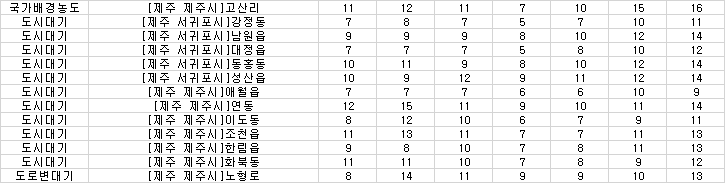